<a href="https://colab.research.google.com/github/beaten-by-the-market/krxnewsscrap/blob/main/krxvsnxt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 파이썬 세팅하고 조회일자 입력하기

In [1]:
#-----------------------------------------------------------
#필요한 패키지 import
#-----------------------------------------------------------
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from matplotlib import font_manager, rc
import numpy as np
from datetime import datetime

print('파이썬 실행을 위한 패키지 설치중입니다. 20초정도 소요됩니다.')

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# Matplotlib 폰트 캐시 삭제
font_manager.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
font_manager._load_fontmanager(try_read_cache=False)

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 조회할 날짜 선택하기
print('조회할 날짜를 YYYYMMDD 형태로 입력하고 엔터키를 치세요 (ex. 20250304)')
input_date = input()
# 날짜를 '오늘'로 지정하려면 : input_date = datetime.today().strftime('%Y%m%d')

파이썬 실행을 위한 패키지 설치중입니다. 20초정도 소요됩니다.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 125044 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-

## NXT, KRX 데이터 표로 보기

In [2]:
#-----------------------------------------------------------
#데이터 불러오기(NXT와 KRX 모두)
#-----------------------------------------------------------
# 넥스트레이드
url = 'https://www.nextrade.co.kr/brdinfoTime/brdinfoTimeList.do'

params = {
    "_search": False,
    "nd": 1741120157913,
    "pageUnit": 900,
    "pageIndex": 1,
    "sidx": "",
    "sord": "asc",
    "scAggDd": input_date,
    "scMktId": "",
    "searchKeyword": ""
}

# POST 요청
response = requests.post(url, params=params)
data = response.json()  # JSON 데이터 변환

# 필요한 데이터 리스트 추출
brdinfo_list = data.get("brdinfoTimeList", [])

# 데이터프레임 전환
df1 = pd.DataFrame(brdinfo_list)
df_nxt = df1[['isuSrdCd', 'isuAbwdNm', 'mktNm', 'curPrc', 'contrastPrc', 'upDownRate', 'oppr', 'hgpr', 'lwpr', 'accTdQty', 'accTrval', 'tdhlYn']]

# 데이터프레임으로 변환할 컬럼 정의
df_nxt.columns = ['종목코드', '종목명', '시장구분', '현재가', '대비', '등락률', '시가', '고가', '저가', '거래량', '거래대금', '거래정지']

#종목코드의 첫 앞의 A를 제거하기
df_nxt = df_nxt.copy()  # 명시적으로 새로운 데이터프레임 생성
df_nxt['종목코드'] = df_nxt['종목코드'].str.replace('A', '', regex=True)

# 필요한 칼럼만 남기기
df_nxt = df_nxt[['종목코드', '종목명', '시장구분', '현재가', '등락률', '거래량', '거래대금']]

# 칼럼명 변경하기
df_nxt = df_nxt.rename(columns={'현재가': 'NXT현재가', '등락률': 'NXT등락률', '거래량': 'NXT거래량', '거래대금':'NXT거래대금'})

#-----------------------------------------------------------
#정보데이터시스템에서 불러오는 과정
#-----------------------------------------------------------

#[12001] 전종목 시세
#거래소 홈페이지에서 불러오기
gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp = {
    'locale' : 'ko_KR',
    'mktId': 'ALL',
    'trdDd': input_date,
    'share': '1',
    'money': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/standard/MDCSTAT01501'
    }

headers = {'Referer' : 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020201',
           'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

otp = requests.post(gen_otp_url, gen_otp, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)


df_krx = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')
df_krx['시장구분'] = df_krx['시장구분'].replace('KOSDAQ GLOBAL', 'KOSDAQ')
df_krx = df_krx.rename(columns=({'단축코드':'stock_code'}))

# 필요한 칼럼만 남기기
df_krx = df_krx[['종목코드', '종가', '등락률', '거래량', '거래대금', '시가총액']]

# 칼럼명 변경하기
df_krx = df_krx.rename(columns={'종가': 'KRX종가','등락률': 'KRX종가등락률', '거래량': 'KRX거래량', '거래대금': 'KRX거래대금'})


# 데이터 합치기
df_agg = pd.merge(df_nxt, df_krx, on='종목코드', how='left')
df_agg['비중'] = 100*(df_agg['NXT거래량']/df_agg['KRX거래량'])
df_agg = df_agg.copy()[['종목코드', '종목명', '시장구분', 'NXT거래량','KRX거래량', '비중','시가총액']].sort_values(by='비중', ascending=False)

# 넥스트레이드 기준 날짜 및 시각 출력
if data.get("brdinfoTimeList"):
    now_date = data["setTime"]
    print(f"넥스트레이드 기준 날짜: {now_date}")
else:
    print("데이터가 없습니다.")

# **추가: 전체 거래량 합산 및 비율 계산**
total_nxt_vol = df_agg['NXT거래량'].sum()
total_krx_vol = df_agg['KRX거래량'].sum()
nxt_vs_krx_ratio = (total_nxt_vol / total_krx_vol) * 100 if total_krx_vol > 0 else 0

# 상단에 정보 추가
print(f"📌 {now_date} NXT는 KRX의 거래량 대비 **{nxt_vs_krx_ratio:.2f}%**를 기록했습니다.\n\n")

# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

def format_market_cap(value):
    if isinstance(value, (int, float)):
        return f"{value / 100000000:,.0f}"  # 억원 단위 변환 후 천 단위 콤마 추가
    return value

# 데이터프레임 복사
df_display = df_agg.copy()

# 종목코드 및 비중을 제외한 컬럼에 천단위 콤마 추가
for col in df_display.columns:
    if col == '비중':
        df_display[col] = df_display[col].apply(format_percentage)  # 비중 칼럼은 소수점 2자리
    elif col == '시가총액':
        df_display[col] = df_display[col].apply(format_market_cap)  # 시가총액을 억원 단위로 변환
    elif col not in ['종목코드', '비중']:
        df_display[col] = df_display[col].apply(format_number)  # 나머지는 천단위 콤마 적용

# 시가총액 칼럼을 시가총액(억원)으로 이름 바꾸기
df_display = df_display.rename(columns={'시가총액': '시가총액(억원)'})

# 데이터프레임 출력
df_display

넥스트레이드 기준 날짜: 2025-03-17 10:32
📌 2025-03-17 10:32 NXT는 KRX의 거래량 대비 **30.16%**를 기록했습니다.




,종목코드,종목명,시장구분,NXT거래량,KRX거래량,비중,시가총액(억원)
26,086450,동국제약,KOSDAQ,"33,687","47,025",71.64,"6,722"
3,009520,포스코엠텍,KOSDAQ,"257,480","449,751",57.25,"6,063"
19,108860,셀바스AI,KOSDAQ,"50,891","92,045",55.29,"3,555"
1,222800,심텍,KOSDAQ,"267,786","615,586",43.50,"6,833"
9,058610,에스피지,KOSDAQ,"31,134","73,077",42.60,"5,822"
...,...,...,...,...,...,...,...
80,039490,키움증권,KOSPI,864,"14,793",5.84,"30,964"
106,069080,웹젠,KOSDAQ,"1,063","19,464",5.46,"4,439"
107,012750,에스원,KOSPI,193,"6,187",3.12,"23,483"
109,002840,미원상사,KOSPI,32,"1,062",3.01,"8,564"


## NXT, KRX 데이터 시각화해서 보기

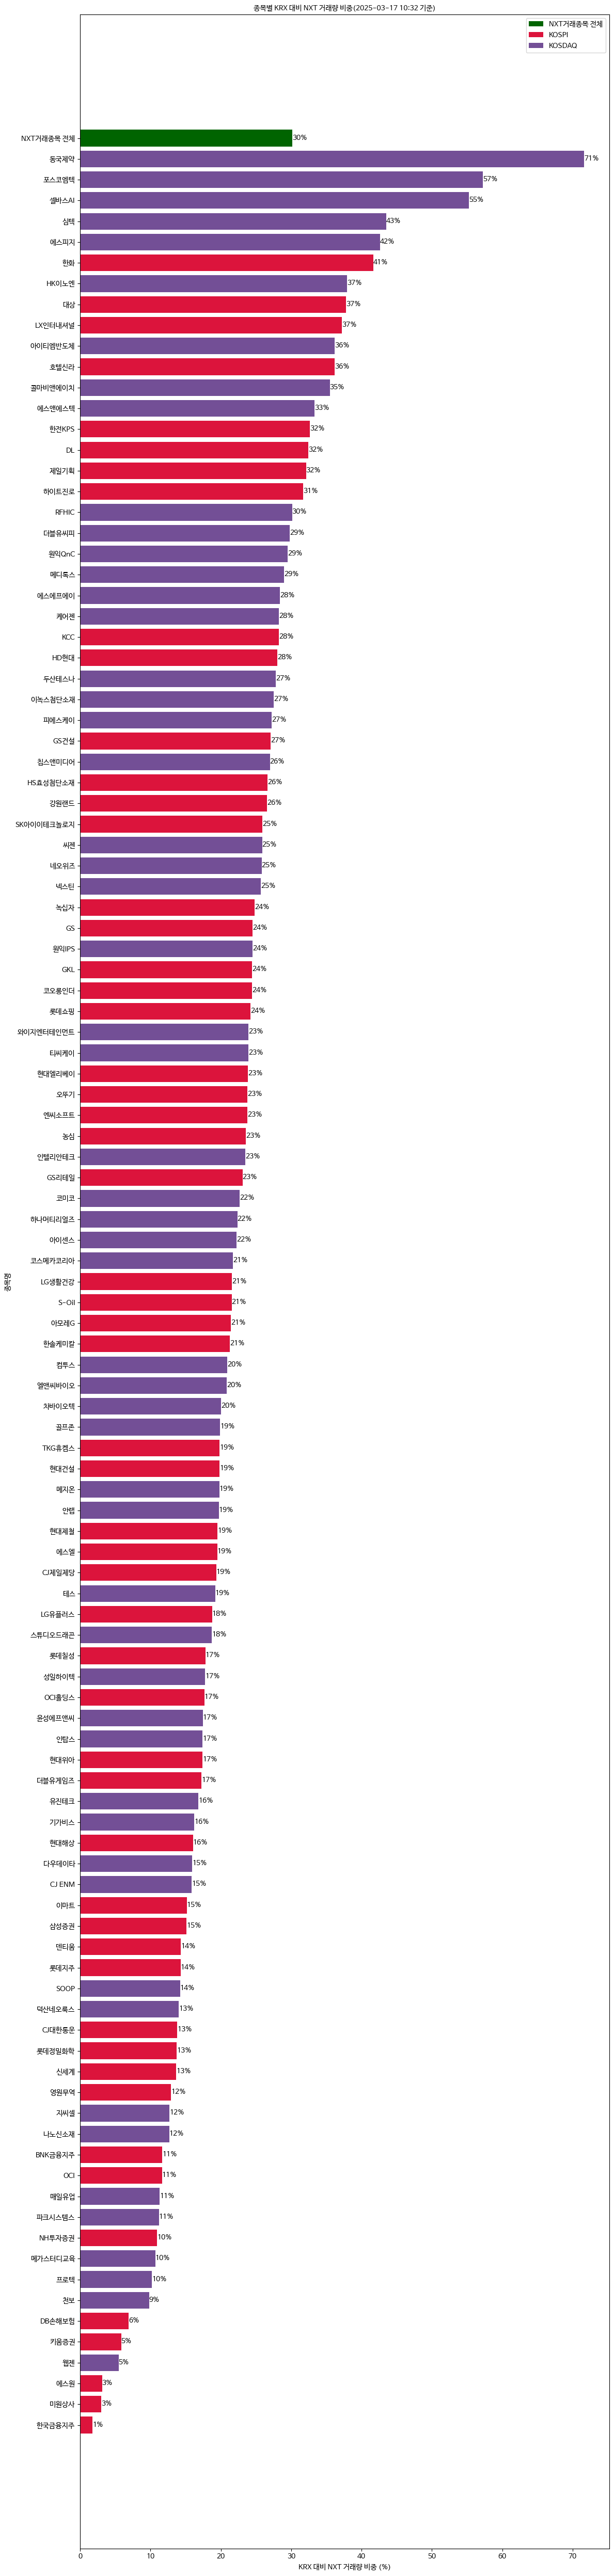

In [4]:
#-----------------------------------------------------------
#차트 생성
#-----------------------------------------------------------
plt.figure(figsize=(12, 50))  # 차트 크기를 조금 더 크게 조정

# 색상 지정
colors = np.where(df_agg['시장구분'] == 'KOSPI', 'crimson', '#734F96')

# 전체 시장 데이터 추가
all_data = df_agg['비중'].tolist()
all_data.insert(0, nxt_vs_krx_ratio)
all_labels = df_agg['종목명'].tolist()
all_labels.insert(0, 'NXT거래종목 전체')
all_colors = np.append(['darkgreen'], colors)

bars = plt.barh(all_labels, all_data, color=all_colors)
plt.xlabel('KRX 대비 NXT 거래량 비중 (%)', fontproperties=font_prop)
plt.ylabel('종목명', fontproperties=font_prop)
plt.title(f'종목별 KRX 대비 NXT 거래량 비중({now_date} 기준)', fontproperties=font_prop)
plt.gca().invert_yaxis()

# 데이터 레이블 추가
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{int(width)}%',
             ha='left', va='center', fontproperties=font_prop)

# 범례 추가
kospi_patch = plt.Rectangle((0,0),1,1,fc="crimson", edgecolor = 'none')
kosdaq_patch = plt.Rectangle((0,0),1,1,fc="#734F96", edgecolor = 'none')
market_patch = plt.Rectangle((0,0),1,1,fc="darkgreen", edgecolor = 'none')
plt.legend([market_patch, kospi_patch, kosdaq_patch], ['NXT거래종목 전체', 'KOSPI', 'KOSDAQ'], prop=font_prop)

plt.tight_layout()

# y축 레이블 폰트 설정
for label in plt.gca().get_yticklabels():
    label.set_fontproperties(font_prop)

plt.show()


[(링크)[그래픽] 종목별 한국거래소 대비 넥스트레이드 거래량 비중](https://www.yna.co.kr/view/GYH20250304001100044?input=1363m)

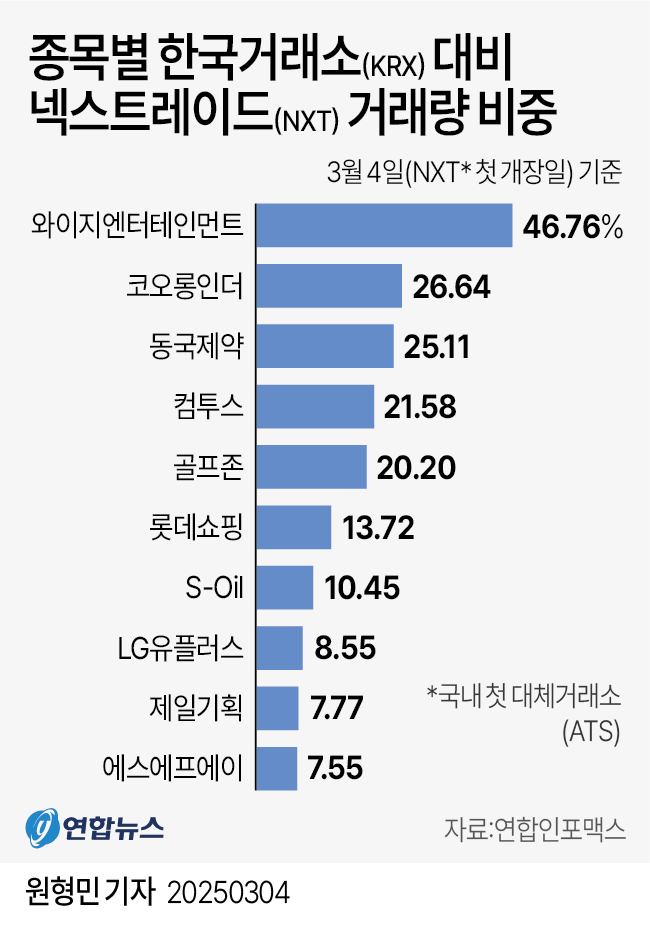